# Country coverage
This notebook uses the `EmissionsPeakTest` class, defined in the scripts section, to test how many countries would be defined as having peaked by now using the statistical test that we identify here

## Load packages

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../scripts')

from peak_tester import EmissionsPeakTest
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_indexing as pix
from pandas_indexing import *


## Fossil co2 implementation

### Basic analysis
- Testing whether EU has peaked to start

In [3]:
import os, sys

class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w', encoding='utf-8')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

In [4]:
gcb_data = pd.read_csv('../data/processed/gcb_hist_co2.csv',index_col=[0,1,2,3])
gcb_data.columns = gcb_data.columns.astype(int)
gcb_data = gcb_data.loc[~gcb_data.loc[:,1990:].isnull().any(axis=1)]
gcb_data.head()

,,,,1850,1851,1852,1853,1854,1855,1856,1857,1858,1859,...,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
region,region_name,variable,unit,,,,,,,,,,,,,,,,,,,,,
AFG,Afghanistan,Emissions|CO2|Fossil,Mt CO2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,9.384400,8.605932,9.311054,10.191504,10.400110,11.118626,9.868841,10.169889,10.516319,10.825998
ALB,Albania,Emissions|CO2|Fossil,Mt CO2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.712144,4.555035,5.343792,5.194860,4.940528,4.865033,5.137011,4.498282,4.417333,4.444448
DZA,Algeria,Emissions|CO2|Fossil,Mt CO2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,160.321614,158.308319,165.251640,174.461176,182.424990,171.138531,182.035819,192.778562,202.846649,198.203189
AND,Andorra,Emissions|CO2|Fossil,Mt CO2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.465328,0.472656,0.472656,0.498304,0.490976,0.377392,0.414032,0.423408,0.418098,0.424663
AGO,Angola,Emissions|CO2|Fossil,Mt CO2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,27.505228,25.465634,23.600985,23.278049,22.210075,16.549341,19.218561,21.089005,21.674816,22.333583


In [5]:
G20_ISOS = ['AUS','ARG','BRA','CAN','CHN','EU27','IND','IDN','JPN','MEX','RUS','SAU','KOR','TUR','GBR','USA','ZAF'] 

In [6]:
likelihood_of_peaking = pd.Series()

#This is time intensive – roughly 1.5 seconds per country
with HiddenPrints():
    for region in G20_ISOS: #list(gcb_data.pix.project('region').index)[:]:
        peak_tester = EmissionsPeakTest()
        peak_tester.load_historical_data(
            'gcb_hist_co2.csv', region=region,year_range = range(1990,2024))
        peak_tester.characterize_noise(method='loess', fraction=0.25,noise_type = 't-dist')
        peak_tester.create_noise_generator()
        peak_tester.set_test_data(
            list(
                peak_tester.historical_data.loc[
                    peak_tester.historical_data.year.isin(range(2014,2024))
                    ].itertuples(index=False, name=None)
            )).run_complete_bootstrap_test(bootstrap_method='ar_bootstrap')
        likelihood_of_peaking.loc[region] = 1 - peak_tester.bootstrap_results['p_value_one_tail']


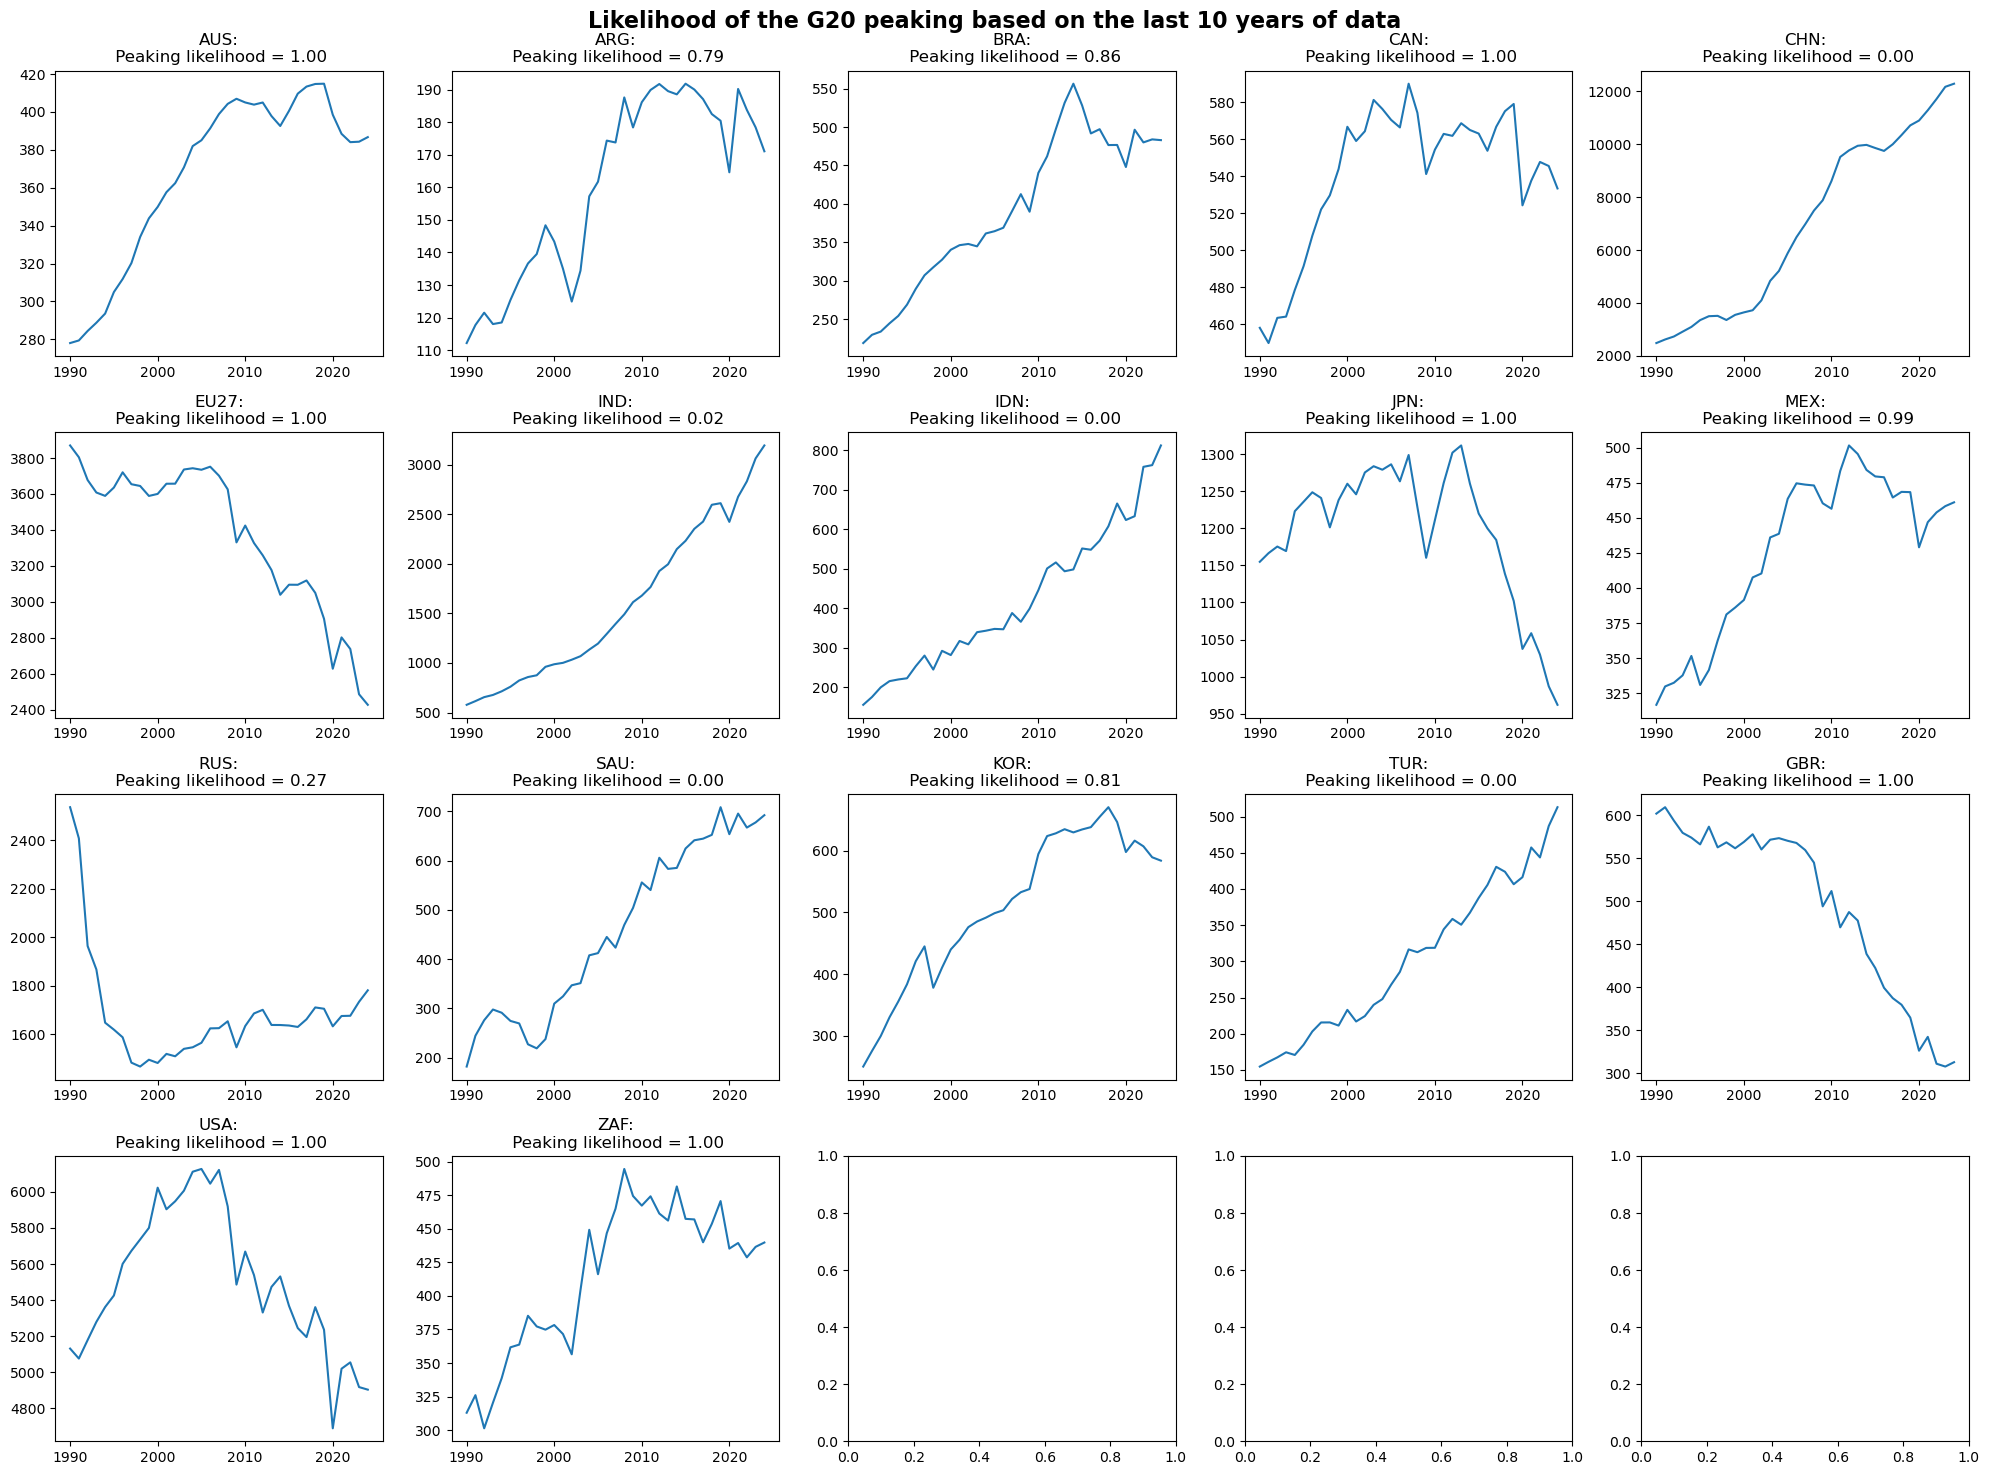

In [7]:
f, axes = plt.subplots(nrows=4,ncols=5,figsize=(20,15))

for count, ax in enumerate(axes.ravel()[:-3]):
    gcb_data.loc[isin(region=G20_ISOS[count]),1990:].T.plot(ax=ax,legend=False)
    ax.set_title(f'{G20_ISOS[count]}:\n Peaking likelihood = {likelihood_of_peaking[G20_ISOS[count]]:.2f}')


f.suptitle('Likelihood of the G20 peaking based on the last 10 years of data', fontweight='bold',fontsize=16)
plt.tight_layout()

## To further explore, work in progress
Looking at whether noise characterisation varies pre- and post- peak for countries

In [8]:
noise_characterisation = pd.DataFrame(index=G20_ISOS,columns=range(2000,2025))

with HiddenPrints():
    for region in G20_ISOS:
        peak_tester = EmissionsPeakTest()       
        peak_tester.load_historical_data(
        'gcb_hist_co2.csv', region=region,year_range = range(1990,2025))
     #This is time intensive – roughly 1.5 seconds per country
        for year in range(2000,2024): #list(gcb_data.pix.project('region').index)[:]:

            peak_tester.characterize_noise(
                method='loess',
                ignore_years=range(year,2024),
                #Scaling the fraction considered so that with a smaller set of years you take a larger fraction 
                # #[otherwise noise goes to zero]
                fraction=0.15*(2024-1990)/(year-1990), 
                noise_type = 't-dist')
            noise_characterisation.loc[region,year] = peak_tester.autocorr_params['sigma_residuals']


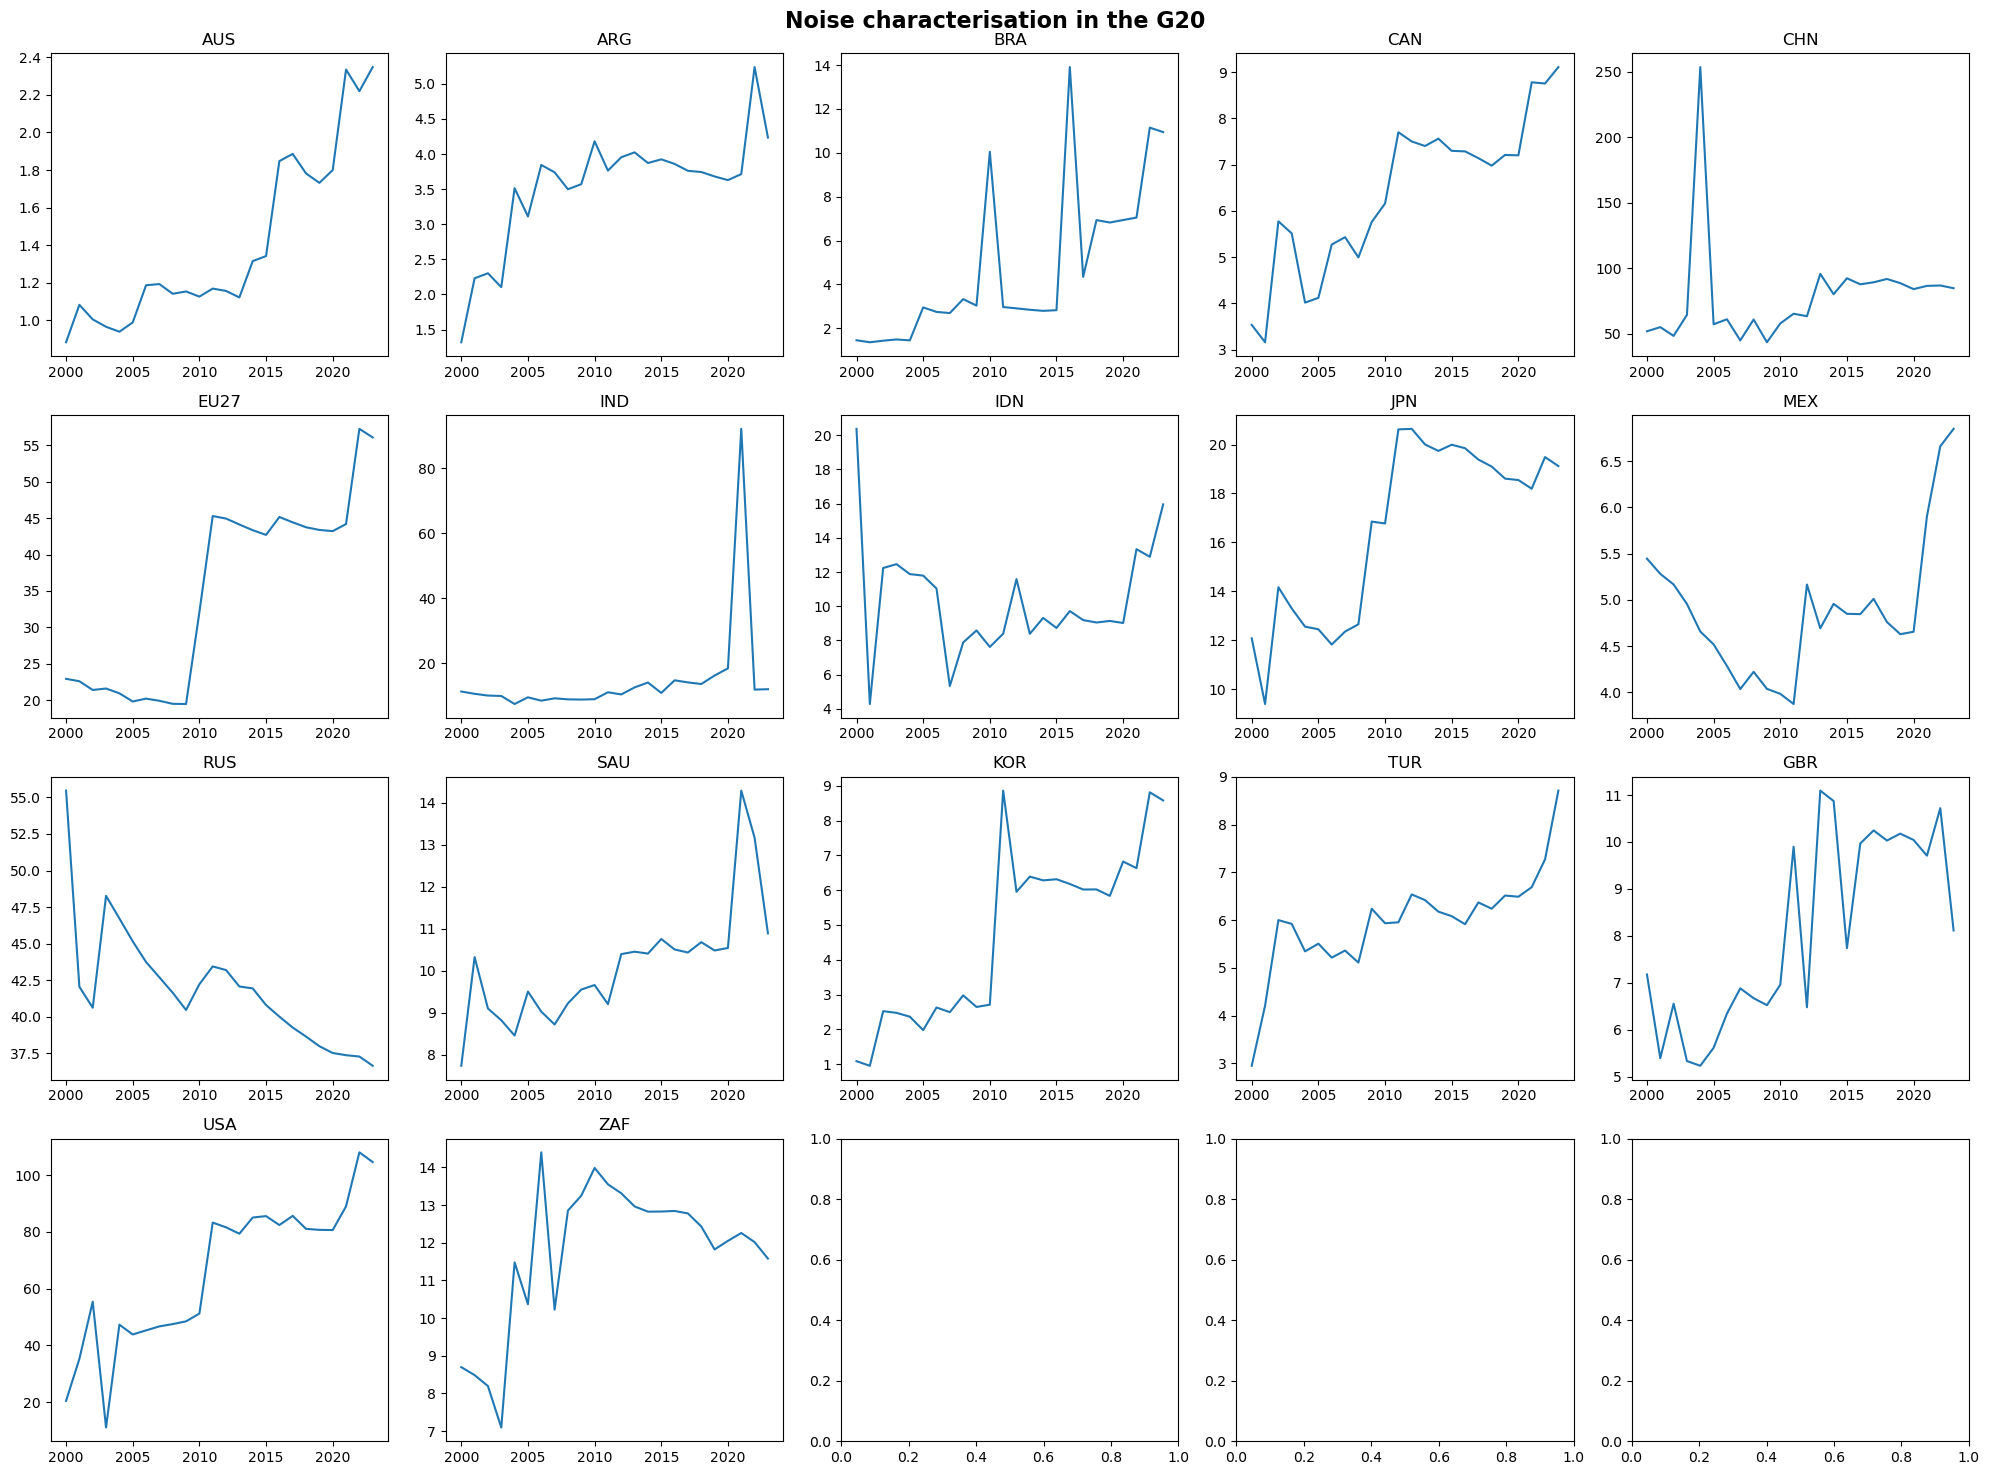

In [9]:
f, axes = plt.subplots(nrows=4,ncols=5,figsize=(20,15))

for count, ax in enumerate(axes.ravel()[:-3]):
    noise_characterisation.loc[G20_ISOS[count],2000:].T.plot(ax=ax,legend=False)
    ax.set_title(f'{G20_ISOS[count]}')

f.suptitle('Noise characterisation in the G20', fontweight='bold',fontsize=16)
plt.tight_layout()

Loaded historical data: 1990-2023
Data points: 34


<Axes: >

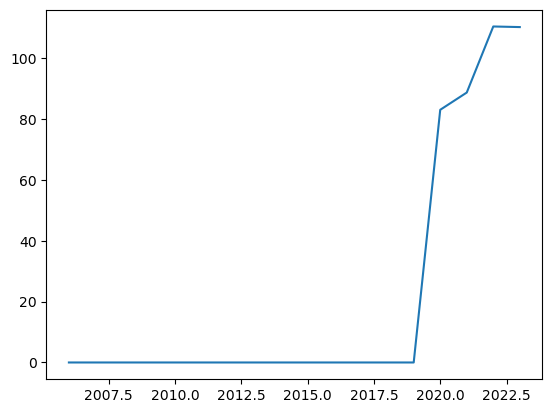

In [10]:
noise_characterisation = pd.Series()

peak_tester = EmissionsPeakTest()
peak_tester.load_historical_data(
    'gcb_hist_co2.csv', region='USA',year_range = range(1990,2024))
#This is time intensive – roughly 1.5 seconds per country
with HiddenPrints():
    for year in range(2006,2024): #list(gcb_data.pix.project('region').index)[:]:

        peak_tester.characterize_noise(method='loess', ignore_years=range(year,2024), fraction=0.15*(year-1990)/(2023-1990),noise_type = 't-dist')
        noise_characterisation.loc[year] = peak_tester.autocorr_params['sigma_residuals']

noise_characterisation.plot()

In [11]:
noise_characterisation

2006      0.000000
2007      0.000000
2008      0.000000
2009      0.000000
2010      0.000000
2011      0.000000
2012      0.000000
2013      0.000000
2014      0.000000
2015      0.000000
2016      0.000000
2017      0.000000
2018      0.000000
2019      0.000000
2020     82.993796
2021     88.657260
2022    110.357598
2023    110.159732
dtype: float64

In [12]:
likelihood_of_peaking

AUS     0.9999
ARG     0.7926
BRA     0.8571
CAN     0.9951
CHN     0.0002
EU27    1.0000
IND     0.0181
IDN     0.0000
JPN     0.9983
MEX     0.9942
RUS     0.2678
SAU     0.0000
KOR     0.8145
TUR     0.0000
GBR     0.9999
USA     1.0000
ZAF     0.9972
dtype: float64

In [13]:
likelihood_of_peaking

AUS     0.9999
ARG     0.7926
BRA     0.8571
CAN     0.9951
CHN     0.0002
EU27    1.0000
IND     0.0181
IDN     0.0000
JPN     0.9983
MEX     0.9942
RUS     0.2678
SAU     0.0000
KOR     0.8145
TUR     0.0000
GBR     0.9999
USA     1.0000
ZAF     0.9972
dtype: float64

In [14]:
peak_tester.plot_analysis()

ValueError: Must run bootstrap test first

### Test impact of adding ignore_years

In [9]:
peak_tester.characterize_noise(method='hp')
peak_tester.characterize_noise(method='hp',ignore_years=[1992, 1993, 2008, 2009, 2020, 2021])

using normal distribution to calculate noise
Autocorrelation analysis:
  Lag-1 autocorr: 0.399
  Residual σ (post-autocorrelation): 462.1
  Has significant autocorr: True
  Likelihood of autocorr: 0.9891095773301503
Noise characterization complete:
  Method used: hp
using normal distribution to calculate noise
Autocorrelation analysis:
  Lag-1 autocorr: 0.741
  Residual σ (post-autocorrelation): 333.0
  Has significant autocorr: True
  Likelihood of autocorr: 0.9999999618417601
Noise characterization complete:
  Method used: hp


In [10]:
peak_tester.characterize_noise(method='loess')
peak_tester.characterize_noise(method='loess',ignore_years=[1992, 1993, 2008, 2009, 2020, 2021])

using normal distribution to calculate noise
Autocorrelation analysis:
  Lag-1 autocorr: 0.406
  Residual σ (post-autocorrelation): 468.9
  Has significant autocorr: True
  Likelihood of autocorr: 0.9909892669917686
Noise characterization complete:
  Method used: loess
using normal distribution to calculate noise
Autocorrelation analysis:
  Lag-1 autocorr: 0.591
  Residual σ (post-autocorrelation): 329.1
  Has significant autocorr: True
  Likelihood of autocorr: 0.9999165983843805
Noise characterization complete:
  Method used: loess


In [11]:
peak_tester.characterize_noise(method='hamilton')
peak_tester.characterize_noise(method='hamilton',ignore_years=[1992, 1993, 2008, 2009, 2020, 2021])

using normal distribution to calculate noise
Autocorrelation analysis:
  Lag-1 autocorr: -0.006
  Residual σ (post-autocorrelation): 628.9
  Has significant autocorr: False
  Likelihood of autocorr: 0.0063212162042093345
Noise characterization complete:
  Method used: hamilton
using normal distribution to calculate noise
Autocorrelation analysis:
  Lag-1 autocorr: 0.081
  Residual σ (post-autocorrelation): 355.9
  Has significant autocorr: False
  Likelihood of autocorr: 0.32845341857014976
Noise characterization complete:
  Method used: hamilton
